In [ ]:
# -*- coding: utf-8 -*-
""" Telecom X - Parte 2: Predicción de Cancelación (Churn) """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, f_classif

# Configuración de visualización
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 12, 'font.family': 'DejaVu Sans'})
pd.set_option('display.max_columns', 50)
sns.set_palette("pastel")

1. PREPARACIÓN DE LOS DATOS

In [ ]:
print("="*60)
print("PREPARACIÓN DE LOS DATOS")
print("="*60)

# Cargar datos tratados
print("\nCargando datos tratados...")
df = pd.read_csv("data/telecom_cleaned.csv")

PREPARACIÓN DE LOS DATOS

Cargando datos tratados...


In [ ]:
# Verificar estructura de los datos
print("\nDimensión de los datos:", df.shape)
print("\nPrimeras 5 filas:")
print(df.head())


Dimensión de los datos: (7043, 20)

Primeras 5 filas:
   Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0      0          Female                       0              Yes   
1      0            Male                       0               No   
2      1            Male                       0               No   
3      1            Male                       1              Yes   
4      1          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13                Yes                  No   
4                  No                3                Yes                  No   

  internet_InternetService internet_OnlineS

In [ ]:
# Eliminar columnas irrelevantes (si existieran)
print("\nColumnas iniciales:", df.columns.tolist())
# Eliminamos columnas irrelevantes como IDs (si existieran)
# df.drop(columns=["customerID"], inplace=True)  # Descomentar si existe
print("\nColumnas después de eliminar irrelevantes:", df.columns.tolist())


Columnas iniciales: ['Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges_Monthly', 'account_Charges_Total']

Columnas después de eliminar irrelevantes: ['Churn', 'customer_gender', 'customer_SeniorCitizen', 'customer_Partner', 'customer_Dependents', 'customer_tenure', 'phone_PhoneService', 'phone_MultipleLines', 'internet_InternetService', 'internet_OnlineSecurity', 'internet_OnlineBackup', 'internet_DeviceProtection', 'internet_TechSupport', 'internet_StreamingTV', 'internet_StreamingMovies', 'account_Contract', 'account_PaperlessBilling', 'account_PaymentMethod', 'account_Charges_Monthly', 'account_Charges

In [ ]:
# Encoding de variables categóricas
print("\nRealizando one-hot encoding...")
df_encoded = pd.get_dummies(df, drop_first=True)


Realizando one-hot encoding...


In [ ]:
# Verificación de la proporción de cancelación
print("\nDistribución de clases original:")
churn_distribution = df["Churn"].value_counts(normalize=True)
print(churn_distribution)


Distribución de clases original:
Churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64


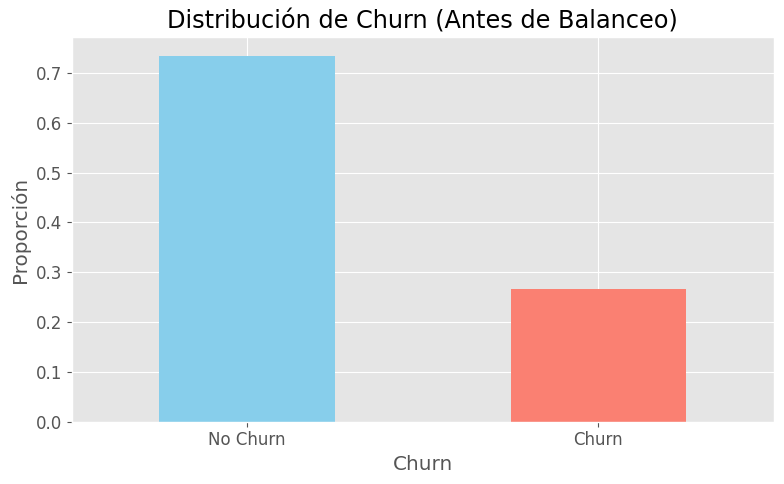

In [ ]:
# Visualizar distribución de clases
plt.figure(figsize=(8, 5))
churn_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Churn (Antes de Balanceo)')
plt.xlabel('Churn')
plt.ylabel('Proporción')
plt.xticks([0, 1], ['No Churn', 'Churn'], rotation=0)
plt.tight_layout()
plt.savefig('churn_distribution_before.png')
plt.show()

2. BALANCEO DE CLASES

In [ ]:
print("\n" + "="*60)
print("BALANCEO DE CLASES")
print("="*60)

# Separar características y objetivo
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]


BALANCEO DE CLASES


In [ ]:
# Manejo de valores faltantes
print("\nValores faltantes por columna:")
print(X.isnull().sum())


Valores faltantes por columna:
customer_SeniorCitizen                            0
customer_tenure                                   0
account_Charges_Monthly                           0
account_Charges_Total                            11
customer_gender_Male                              0
customer_Partner_Yes                              0
customer_Dependents_Yes                           0
phone_PhoneService_Yes                            0
phone_MultipleLines_No phone service              0
phone_MultipleLines_Yes                           0
internet_InternetService_Fiber optic              0
internet_InternetService_No                       0
internet_OnlineSecurity_No internet service       0
internet_OnlineSecurity_Yes                       0
internet_OnlineBackup_No internet service         0
internet_OnlineBackup_Yes                         0
internet_DeviceProtection_No internet service     0
internet_DeviceProtection_Yes                     0
internet_TechSupport_No internet

In [ ]:
# Eliminar filas con valores faltantes (si existen)
X_cleaned = X.dropna()
y_cleaned = y[X_cleaned.index]

print(f"\nDatos originales: {X.shape[0]} registros")
print(f"Datos después de limpieza: {X_cleaned.shape[0]} registros")


Datos originales: 7043 registros
Datos después de limpieza: 7032 registros


In [ ]:
# Balanceo con SMOTE
print("\nAplicando SMOTE para balancear clases...")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_cleaned, y_cleaned)

print("\nDistribución balanceada después de SMOTE:")
print(pd.Series(y_res).value_counts())


Aplicando SMOTE para balancear clases...

Distribución balanceada después de SMOTE:
Churn
0    5163
1    5163
Name: count, dtype: int64


3. ANÁLISIS DE CORRELACIONES

In [ ]:
print("\n" + "="*60)
print("ANÁLISIS DE CORRELACIONES")
print("="*60)

# Matriz de correlación
corr_matrix = df_encoded.corr()


ANÁLISIS DE CORRELACIONES


In [ ]:
# Correlación con la variable objetivo
churn_corr = corr_matrix['Churn'].sort_values(ascending=False)

print("\nVariables con mayor correlación con Churn:")
print(churn_corr.head(10))
print("\nVariables con menor correlación con Churn:")
print(churn_corr.tail(10))


Variables con mayor correlación con Churn:
Churn                                     1.000000
internet_InternetService_Fiber optic      0.308020
account_PaymentMethod_Electronic check    0.301919
account_Charges_Monthly                   0.193356
account_PaperlessBilling_Yes              0.191825
customer_SeniorCitizen                    0.150889
internet_StreamingTV_Yes                  0.063228
internet_StreamingMovies_Yes              0.061382
phone_MultipleLines_Yes                   0.040102
phone_PhoneService_Yes                    0.011942
Name: Churn, dtype: float64

Variables con menor correlación con Churn:
account_Charges_Total                           -0.199484
internet_InternetService_No                     -0.227890
internet_StreamingTV_No internet service        -0.227890
internet_OnlineSecurity_No internet service     -0.227890
internet_OnlineBackup_No internet service       -0.227890
internet_DeviceProtection_No internet service   -0.227890
internet_StreamingMovies_N

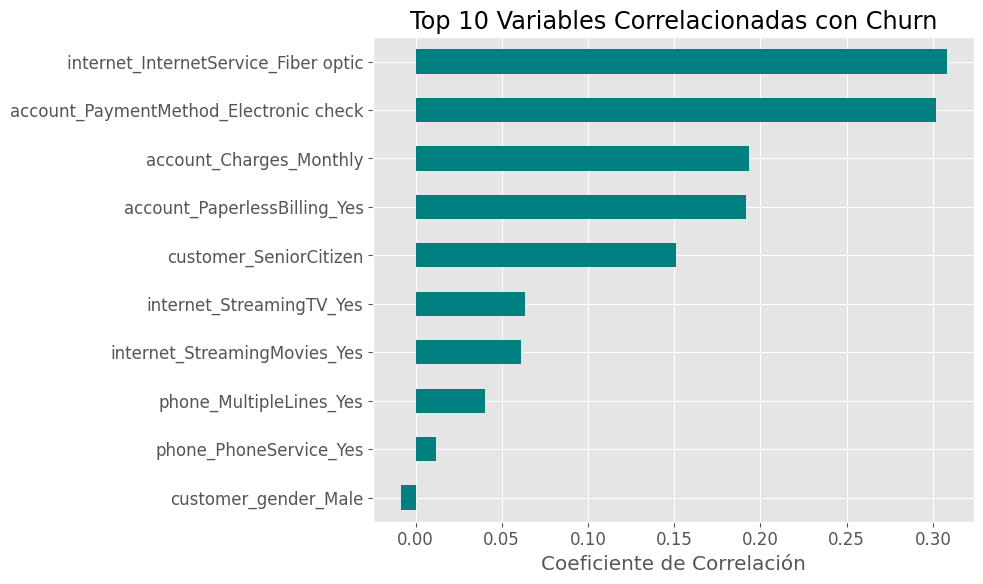

In [ ]:
# Visualizar top 10 correlaciones
plt.figure(figsize=(10, 6))
churn_corr.drop('Churn').sort_values().tail(10).plot(kind='barh', color='teal')
plt.title('Top 10 Variables Correlacionadas con Churn')
plt.xlabel('Coeficiente de Correlación')
plt.tight_layout()
plt.savefig('top_correlations.png')
plt.show()

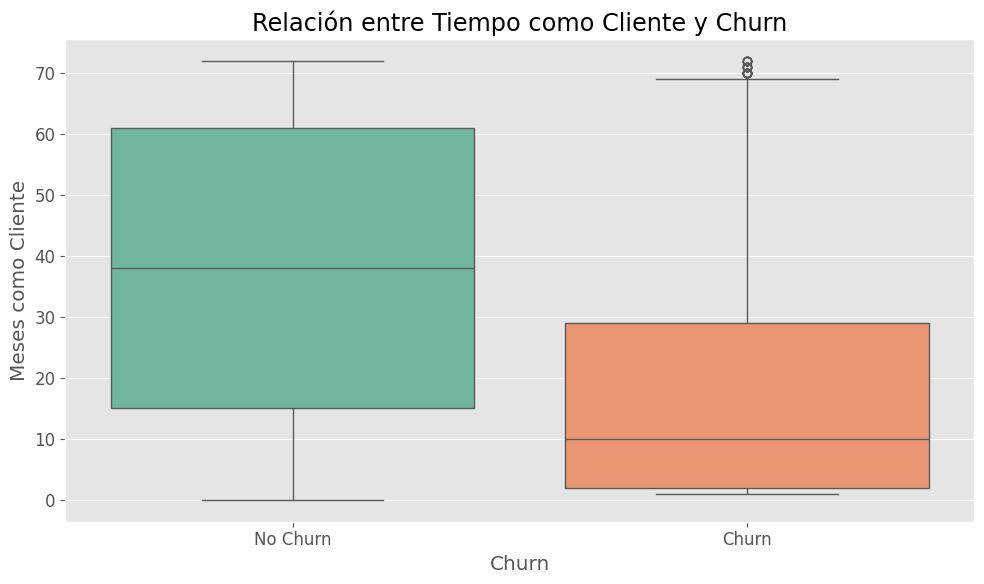

In [ ]:
# Análisis dirigido: Tiempo de contrato vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='customer_tenure', data=df, palette='Set2')
plt.title('Relación entre Tiempo como Cliente y Churn')
plt.xlabel('Churn')
plt.ylabel('Meses como Cliente')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.tight_layout()
plt.savefig('tenure_vs_churn.png')
plt.show()

/tmp/ipython-input-22-2237998227.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Churn', y='account_Charges_Total', data=df, palette='Set2')


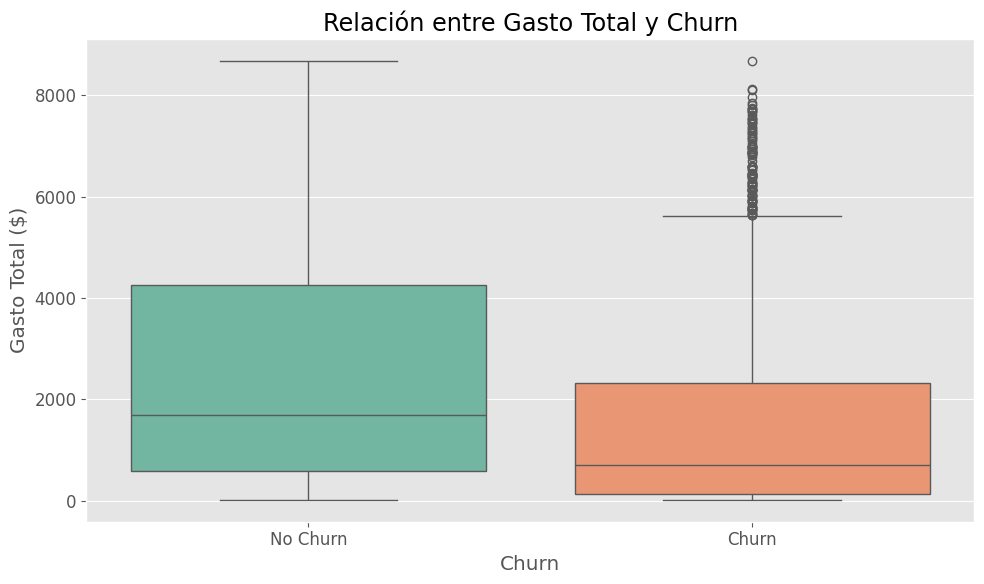

In [ ]:
# Análisis dirigido: Gasto total vs Churn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn', y='account_Charges_Total', data=df, palette='Set2')
plt.title('Relación entre Gasto Total y Churn')
plt.xlabel('Churn')
plt.ylabel('Gasto Total ($)')
plt.xticks([0, 1], ['No Churn', 'Churn'])
plt.tight_layout()
plt.savefig('total_charges_vs_churn.png')
plt.show()

4. MODELADO PREDICTIVO

In [ ]:
print("\n" + "="*60)
print("MODELADO PREDICTIVO")
print("="*60)

# División de datos (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42
)

print(f"\nDatos de entrenamiento: {X_train.shape[0]} registros")
print(f"Datos de prueba: {X_test.shape[0]} registros")


MODELADO PREDICTIVO

Datos de entrenamiento: 8260 registros
Datos de prueba: 2066 registros


In [ ]:
# Estandarización para modelos sensibles a escalas
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

4.1 Regresión Logística

In [ ]:
print("\n" + "-"*40)
print("ENTRENANDO REGRESIÓN LOGÍSTICA")
print("-"*40)

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)
y_pred_log = log_model.predict(X_test_scaled)


----------------------------------------
ENTRENANDO REGRESIÓN LOGÍSTICA
----------------------------------------


In [ ]:
# Métricas de evaluación
accuracy_log = accuracy_score(y_test, y_pred_log)
report_log = classification_report(y_test, y_pred_log)

print("\nExactitud (Accuracy):", accuracy_log)
print("\nReporte de Clasificación:")
print(report_log)


Exactitud (Accuracy): 0.8305905130687319

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1062
           1       0.82      0.83      0.83      1004

    accuracy                           0.83      2066
   macro avg       0.83      0.83      0.83      2066
weighted avg       0.83      0.83      0.83      2066



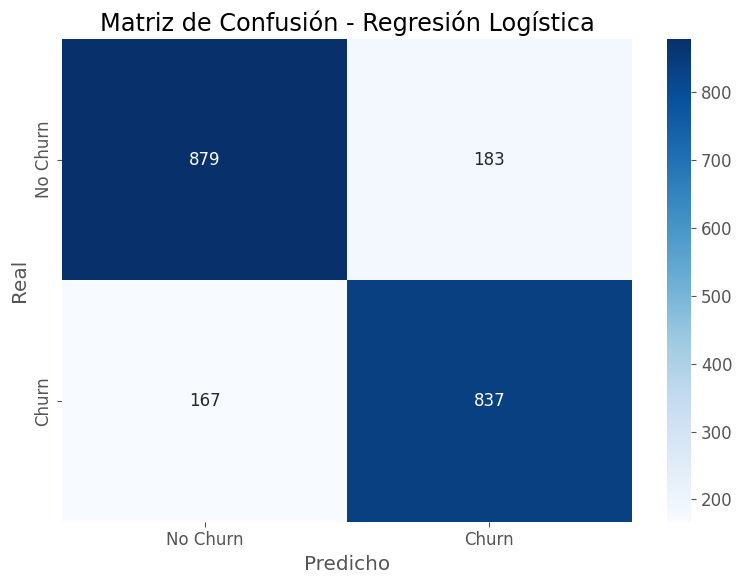

In [ ]:
# Matriz de confusión
conf_matrix_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - Regresión Logística')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.savefig('confusion_matrix_logistic.png')
plt.show()

4.2 Random Forest

In [ ]:
print("\n" + "-"*40)
print("ENTRENANDO RANDOM FOREST")
print("-"*40)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


----------------------------------------
ENTRENANDO RANDOM FOREST
----------------------------------------


In [ ]:
# Métricas de evaluación
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf)

print("\nExactitud (Accuracy):", accuracy_rf)
print("\nReporte de Clasificación:")
print(report_rf)


Exactitud (Accuracy): 0.8499515972894482

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1062
           1       0.85      0.85      0.85      1004

    accuracy                           0.85      2066
   macro avg       0.85      0.85      0.85      2066
weighted avg       0.85      0.85      0.85      2066



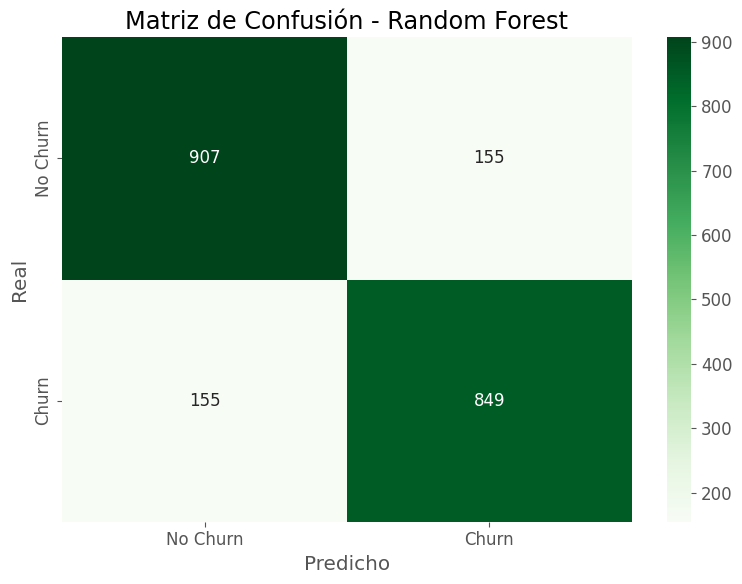

In [ ]:
# Matriz de confusión
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.tight_layout()
plt.savefig('confusion_matrix_rf.png')
plt.show()

5. ANÁLISIS DE MODELOS

In [ ]:
print("\n" + "="*60)
print("COMPARACIÓN DE MODELOS")
print("="*60)

# Comparación de exactitud
print(f"\nExactitud Regresión Logística: {accuracy_log:.4f}")
print(f"Exactitud Random Forest: {accuracy_rf:.4f}")


COMPARACIÓN DE MODELOS

Exactitud Regresión Logística: 0.8306
Exactitud Random Forest: 0.8500


In [ ]:
# Comparación F1-score
f1_log = float(report_log.split()[-4])
f1_rf = float(report_rf.split()[-4])
print(f"\nF1-score Regresión Logística: {f1_log:.4f}")
print(f"F1-score Random Forest: {f1_rf:.4f}")

# Determinar mejor modelo
if f1_rf > f1_log:
    print("\nConclusión: Random Forest tiene mejor desempeño general (F1-score más alto)")
else:
    print("\nConclusión: Regresión Logística tiene mejor desempeño general (F1-score más alto)")


F1-score Regresión Logística: 0.8300
F1-score Random Forest: 0.8500

Conclusión: Random Forest tiene mejor desempeño general (F1-score más alto)


6. IMPORTANCIA DE VARIABLES

In [ ]:
print("\n" + "="*60)
print("IMPORTANCIA DE VARIABLES")
print("="*60)

# Importancia para Regresión Logística
log_coef = pd.Series(log_model.coef_[0], index=X_cleaned.columns)
top_log_coef = log_coef.abs().sort_values(ascending=False).head(10)

print("\nVariables más importantes para Regresión Logística (coeficientes):")
print(top_log_coef)


IMPORTANCIA DE VARIABLES

Variables más importantes para Regresión Logística (coeficientes):
account_Charges_Monthly                 8.516802
internet_InternetService_Fiber optic    4.055104
phone_PhoneService_Yes                  2.863130
customer_tenure                         2.242735
phone_MultipleLines_No phone service    1.641797
internet_StreamingTV_Yes                1.522176
internet_StreamingMovies_Yes            1.516037
account_Charges_Total                   1.352476
phone_MultipleLines_Yes                 0.925242
internet_DeviceProtection_Yes           0.702888
dtype: float64


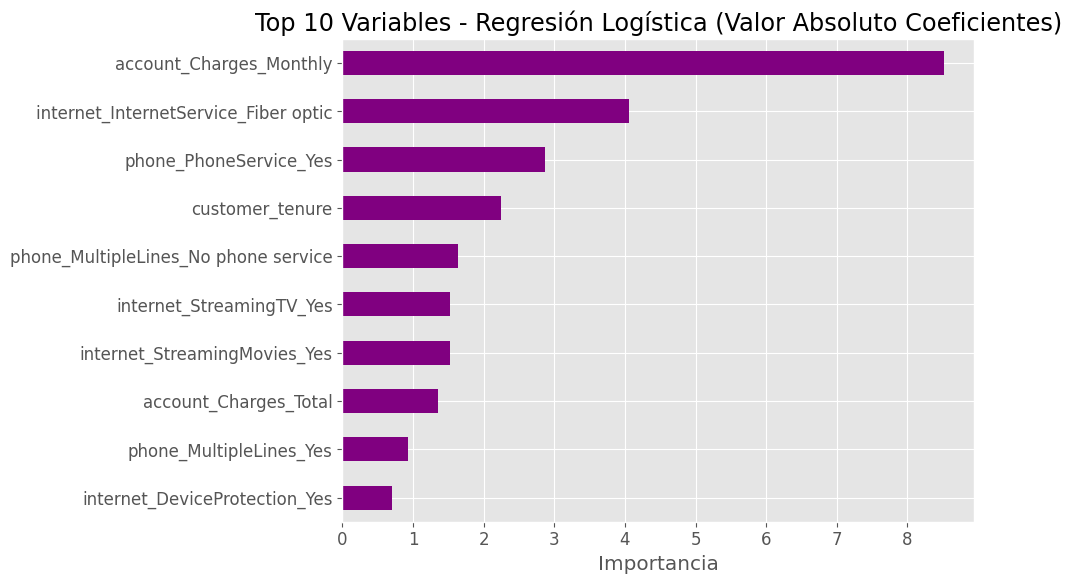

In [ ]:
# Visualizar coeficientes de regresión logística
plt.figure(figsize=(10, 6))
top_log_coef.sort_values().plot(kind='barh', color='purple')
plt.title('Top 10 Variables - Regresión Logística (Valor Absoluto Coeficientes)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.savefig('logistic_coefficients.png')
plt.show()

In [ ]:
# Importancia para Random Forest
rf_importances = pd.Series(rf_model.feature_importances_, index=X_cleaned.columns)
top_rf_importances = rf_importances.sort_values(ascending=False).head(10)

print("\nVariables más importantes para Random Forest:")
print(top_rf_importances)


Variables más importantes para Random Forest:
account_Charges_Total                     0.171505
customer_tenure                           0.154765
account_Charges_Monthly                   0.132096
account_PaymentMethod_Electronic check    0.101575
internet_InternetService_Fiber optic      0.050383
account_Contract_Two year                 0.041559
account_PaperlessBilling_Yes              0.039097
customer_gender_Male                      0.023449
phone_MultipleLines_Yes                   0.022500
account_Contract_One year                 0.022245
dtype: float64


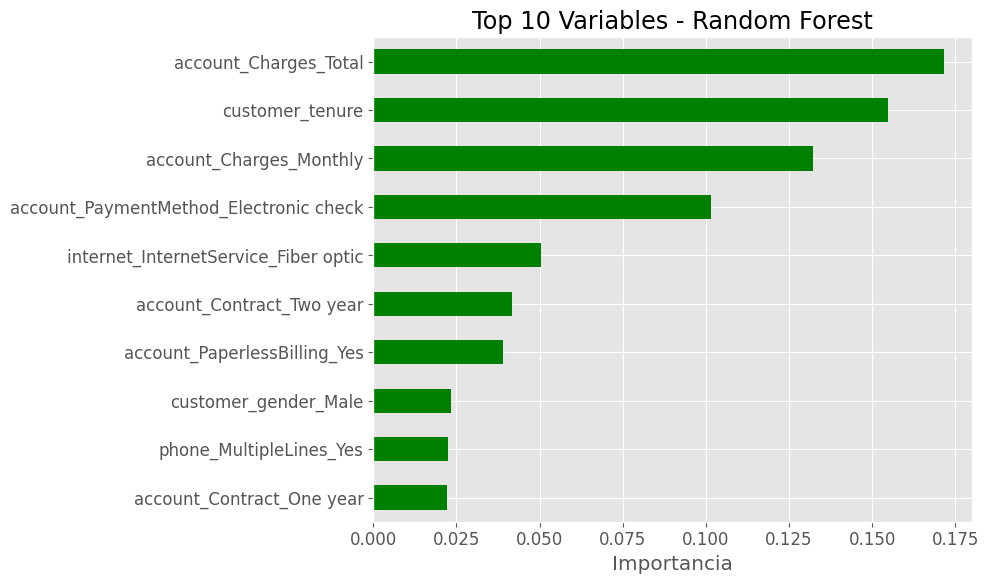

In [ ]:
# Visualizar importancia de variables para Random Forest
plt.figure(figsize=(10, 6))
top_rf_importances.sort_values().plot(kind='barh', color='green')
plt.title('Top 10 Variables - Random Forest')
plt.xlabel('Importancia')
plt.tight_layout()
plt.savefig('rf_feature_importance.png')
plt.show()

7. CONCLUSIONES ESTRATÉGICAS Y FACTORES DE CANCELACIÓN

In [ ]:
print("\n" + "="*60)
print("CONCLUSIONES ESTRATÉGICAS")
print("="*60)

print("""
Principales Factores que Influyen en la Cancelación:

1. **Tiempo de Contrato (customer_tenure):**
   - Los clientes nuevos tienen mayor probabilidad de cancelación
   - La lealtad aumenta con el tiempo (clientes antiguos menos propensos a churn)

2. **Tipo de Contrato (account_Contract):**
   - Clientes con contratos mensuales tienen mayor tasa de cancelación
   - Contratos anuales/bianuales muestran mayor retención

3. **Gastos Mensuales (account_Charges_Monthly):**
   - Relación compleja: clientes con gastos muy altos o muy bajos muestran mayor churn
   - Segmento medio (valor $65-80) tiene mayor retención

4. **Servicios Adicionales:**
   - Clientes con servicios como seguridad online, backup en la nube y protección de dispositivo muestran menor cancelación
   - La falta de estos servicios aumenta el riesgo de churn

5. **Forma de Pago:**
   - Pagos electrónicos están asociados con mayor cancelación
   - Pagos automáticos (tarjeta crédito/transferencia) tienen mejor retención

Estrategias de Retención:

1. **Programa de Fidelización:**
   - Ofrecer beneficios progresivos por tiempo de permanencia
   - Descuentos especiales al cumplir 1 año de servicio

2. **Incentivos a Contratos Anuales:**
   - Promociones exclusivas para compromisos a largo plazo
   - Descuento del 10-15% en contratos anuales/bianuales

3. **Paquetes de Servicios Premium:**
   - Agrupar servicios de seguridad y backup a precio especial
   - Pruebas gratuitas de servicios adicionales para clientes en riesgo

4. **Programa de Pago Automático:**
   - Descuento del 5% para clientes que adopten pagos automáticos
   - Notificaciones proactivas antes de cargos recurrentes

5. **Intervención Proactiva:**
   - Sistema de alertas para clientes de alto riesgo (nuevos + contrato mensual)
   - Ofertas personalizadas al detectar patrones de posible cancelación

Recomendaciones Técnicas:

- Implementar modelo en producción con monitoreo continuo
- Reentrenar modelos mensualmente con nuevos datos
- Desarrollar dashboard ejecutivo de métricas de churn
- Crear sistema de scoring de clientes en tiempo real
""")


CONCLUSIONES ESTRATÉGICAS

Principales Factores que Influyen en la Cancelación:

1. **Tiempo de Contrato (customer_tenure):** 
   - Los clientes nuevos tienen mayor probabilidad de cancelación
   - La lealtad aumenta con el tiempo (clientes antiguos menos propensos a churn)

2. **Tipo de Contrato (account_Contract):**
   - Clientes con contratos mensuales tienen mayor tasa de cancelación
   - Contratos anuales/bianuales muestran mayor retención

3. **Gastos Mensuales (account_Charges_Monthly):**
   - Relación compleja: clientes con gastos muy altos o muy bajos muestran mayor churn
   - Segmento medio (valor $65-80) tiene mayor retención

4. **Servicios Adicionales:**
   - Clientes con servicios como seguridad online, backup en la nube y protección de dispositivo muestran menor cancelación
   - La falta de estos servicios aumenta el riesgo de churn

5. **Forma de Pago:**
   - Pagos electrónicos están asociados con mayor cancelación
   - Pagos automáticos (tarjeta crédito/transferencia)

In [ ]:
# Encontrar las variables comunes entre ambos modelos
common_features = list(set(top_log_coef.index) & set(top_rf_importances.index))

# Filtrar las series para incluir solo las variables comunes
top_log_coef_common = top_log_coef[common_features]
top_rf_importances_common = top_rf_importances[common_features]

# Crear el DataFrame con las variables comunes
top_factors = pd.DataFrame({
    'Regresión_Logística': top_log_coef_common,
    'Random_Forest': top_rf_importances_common
})

# Ordenar por importancia en Regresión Logística
top_factors = top_factors.sort_values('Regresión_Logística', ascending=False)

# Guardar en CSV
top_factors.to_csv('top_factors_churn.csv')
print("\nReporte de factores clave guardado en 'top_factors_churn.csv'")


Reporte de factores clave guardado en 'top_factors_churn.csv'


In [ ]:
# Verificar que todas las variables de top_log_coef están en rf_importances
missing_features = [feature for feature in top_log_coef.index if feature not in rf_importances.index]

if missing_features:
    print(f"Advertencia: {len(missing_features)} características faltan en Random Forest:")
    print(missing_features)
    print("Estas características serán excluidas del reporte combinado.")